In [2]:
import awkward as ak
import uproot
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import sys
import math
from numpy import genfromtxt
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score


sys.path.append('/home/mjovanovic/Work/LCStudies')
from  util import graph_util as gu
from data import particle_data_visualize_plot_utils as pu
%matplotlib inline

In [11]:
def flatten_event_to_cells(event):
    return np.array([cell for clus in event for cell in clus])

def flatten_events_and_clus_to_events(events_data):
    return [[cell_data for clus_data in event_data for cell_data in clus_data] for event_data in events_data]

def flatten_events_to_clus(events_data):
    return [clus_data for event_data in events_data for clus_data in event_data]

def flatten_one_layer(data):
    return [data_layer2 for data_layer1 in data for data_layer2 in data_layer1]

def flatten_layers(data, num_layers=1):
    for i in range(num_layers):
        data = flatten_one_layer(data)
    return data

def flatten_events_to_cells(events_data):
    return [cell_data for clus_data in flatten_events_to_clus(events_data) for cell_data in clus_data]

def DeltaR(etas1, phis1, etas2, phis2):
    return np.sqrt((etas1-etas2)**2 + (phis1-phis2)**2)

In [3]:
new_root_file = uproot.open("~/start_tf/mltree.root")

events = new_root_file["EventTree"]
events_arr = events.arrays(library="ak")
events_arr_np = events.arrays(library="np")

In [4]:
event_idx = 20
clus_idx = 19
cell_idx = 20

print(events.keys())
print("events:", events_arr["eventNumber"])
print(events_arr["cluster_cell_hitsTruthE"])
print("num events:", len(events_arr["cluster_cell_hitsTruthE"]))
print("num clus in event:", len(events_arr["cluster_cell_hitsTruthE"][event_idx]))
print("num cells in clus:", len(events_arr["cluster_cell_hitsTruthE"][event_idx][clus_idx]))
print("cluster_nCells:", events_arr["cluster_nCells"][event_idx][clus_idx])
print("particles with leading deposits (max 3):", events_arr["cluster_cell_hitsTruthE"][event_idx][cell_idx][cell_idx])
print()

print(events_arr["cluster_cell_hitsTruthIndex"])
print("num events:", len(events_arr["cluster_cell_hitsTruthIndex"]))
print("num clus:", len(events_arr["cluster_cell_hitsTruthIndex"][event_idx]))
print("num cells in clus:", len(events_arr["cluster_cell_hitsTruthIndex"][event_idx][clus_idx]))
print("clus particle depositers:", events_arr["cluster_cell_hitsTruthIndex"][event_idx])
print("each cells particle depositers:", events_arr["cluster_cell_hitsTruthIndex"][event_idx][cell_idx])
print("particle idx of leading depositers:", events_arr["cluster_cell_hitsTruthIndex"][event_idx][cell_idx][cell_idx])


['runNumber', 'eventNumber', 'lumiBlock', 'coreFlags', 'mcEventNumber', 'mcChannelNumber', 'mcEventWeight', 'nTruthPart', 'G4PreCalo_n_EM', 'G4PreCalo_E_EM', 'G4PreCalo_n_Had', 'G4PreCalo_E_Had', 'truthVertexX', 'truthVertexY', 'truthVertexZ', 'truthPartPdgId', 'truthPartStatus', 'truthPartBarcode', 'truthPartPt', 'truthPartE', 'truthPartMass', 'truthPartEta', 'truthPartPhi', 'nTrack', 'trackPt', 'trackP', 'trackMass', 'trackEta', 'trackPhi', 'trackTruthParticleIndex', 'trackVisibleCalHitCaloEnergy', 'trackFullCalHitCaloEnergy', 'trackSubtractedCaloEnergy', 'trackNumberOfPixelHits', 'trackNumberOfSCTHits', 'trackNumberOfPixelDeadSensors', 'trackNumberOfSCTDeadSensors', 'trackNumberOfPixelSharedHits', 'trackNumberOfSCTSharedHits', 'trackNumberOfPixelHoles', 'trackNumberOfSCTHoles', 'trackNumberOfInnermostPixelLayerHits', 'trackNumberOfNextToInnermostPixelLayerHits', 'trackExpectInnermostPixelLayerHit', 'trackExpectNextToInnermostPixelLayerHit', 'trackNumberOfTRTHits', 'trackNumberOfTRTO

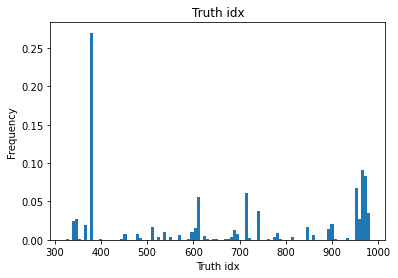

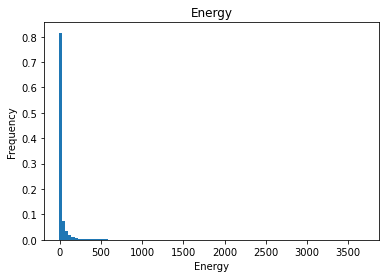

min particle energy deposit: -10.019004821777344
max particle energy deposit 146747.4375
True
25
[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]
frac cells with energy deposits < 0: 0.0024331385492909995
frac events with energy deposits < 0: 1.0


In [24]:
pu.plot_hist([cell for clus in events_arr_np["cluster_cell_hitsTruthIndex"][0] for cells in clus for cell in cells], 100, "Truth idx", "Truth idx", "Frequency")
pu.plot_hist([cell for clus in events_arr_np["cluster_cell_hitsTruthE"][0] for cells in clus for cell in cells], 100, "Energy", "Energy", "Frequency")

print("min particle energy deposit:", ak.min(flatten_layers(events_arr_np["cluster_cell_hitsTruthE"], 3)))
print("max particle energy deposit", ak.max(flatten_layers(events_arr_np["cluster_cell_hitsTruthE"], 3)))

print([np.count_nonzero([1 if cell_part_dep < 0 else 0 for cell_part_dep in flatten_layers(event_part_dep, 2)]) != 0 for event_part_dep in events_arr_np["cluster_cell_hitsTruthE"]])
print("frac cells with energy deposits < 0:", np.count_nonzero(np.array(flatten_layers(events_arr_np["cluster_cell_hitsTruthE"], 3)) < 0)/len(flatten_layers(events_arr_np["cluster_cell_hitsTruthE"], 3)))
print("frac events with energy deposits < 0:", np.count_nonzero([np.count_nonzero([cell_part_dep < 0 for cell_part_dep in flatten_layers(event_part_dep, 2)]) != 0 for event_part_dep in events_arr_np["cluster_cell_hitsTruthE"]]) / len(events_arr_np["cluster_cell_hitsTruthE"]))

nCells 79
num cells (post cut?): 39
num cells: 79
num cells w contribuing particles: 26


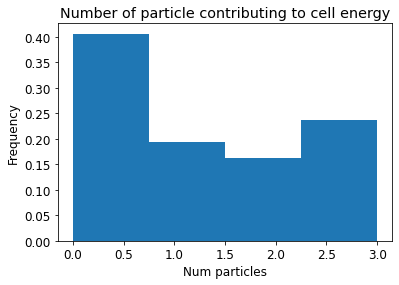

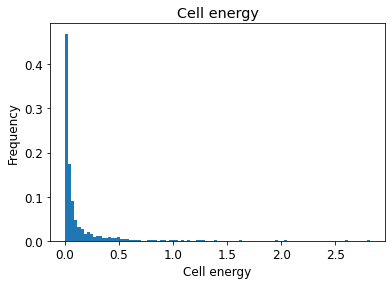

In [257]:
num_truth_contributions = np.array([len(cell_truth_con) for clus_truth_con in events_arr["cluster_cell_hitsTruthIndex"][0] for cell_truth_con in clus_truth_con])
cells_energy = np.array([cell_truth_E for clus_truth_E in events_arr["cluster_cell_E"][0] for cell_truth_E in clus_truth_E])

print("nCells", events_arr["cluster_nCells"][event_idx][clus_idx])
print("num cells (post cut?):", len(events_arr["cluster_cell_E"][event_idx][clus_idx]))
print("num cells:", len(events_arr["cluster_cell_hitsTruthIndex"][event_idx][clus_idx]))
print("num cells w contribuing particles:", np.count_nonzero([len(cont_part) for cont_part in events_arr["cluster_cell_hitsTruthIndex"][event_idx][clus_idx]]))

pu.plot_hist(num_truth_contributions, 4, "Number of particle contributing to cell energy", "Num particles", "Frequency")
#pu.plot_hist(cells_energy[num_truth_contributions == 0], 100, "Cell energy when no particle associated w deposits", "Cell energy", "Frequency")
pu.plot_hist(cells_energy, 100, "Cell energy", "Cell energy", "Frequency")


In [17]:
file = uproot.open("/data/atlas/data/rho_delta/rho_small.root")

events = file["EventTree"]
cell_geo_tree = file["CellGeo"]

events_arr = events.arrays(library="ak")
cell_geo_tree_arr = cell_geo_tree.arrays(library="np")

In [18]:
print(events.keys())

['runNumber', 'eventNumber', 'lumiBlock', 'coreFlags', 'mcEventNumber', 'mcChannelNumber', 'mcEventWeight', 'nTruthPart', 'G4PreCalo_n_EM', 'G4PreCalo_E_EM', 'G4PreCalo_n_Had', 'G4PreCalo_E_Had', 'truthVertexX', 'truthVertexY', 'truthVertexZ', 'truthPartPdgId', 'truthPartStatus', 'truthPartBarcode', 'truthPartPt', 'truthPartE', 'truthPartMass', 'truthPartEta', 'truthPartPhi', 'nTrack', 'trackPt', 'trackP', 'trackMass', 'trackEta', 'trackPhi', 'trackNumberOfPixelHits', 'trackNumberOfSCTHits', 'trackNumberOfPixelDeadSensors', 'trackNumberOfSCTDeadSensors', 'trackNumberOfPixelSharedHits', 'trackNumberOfSCTSharedHits', 'trackNumberOfPixelHoles', 'trackNumberOfSCTHoles', 'trackNumberOfInnermostPixelLayerHits', 'trackNumberOfNextToInnermostPixelLayerHits', 'trackExpectInnermostPixelLayerHit', 'trackExpectNextToInnermostPixelLayerHit', 'trackNumberOfTRTHits', 'trackNumberOfTRTOutliers', 'trackChiSquared', 'trackNumberDOF', 'trackD0', 'trackZ0', 'trackAssocCellID', 'trackAssocCellPathLength', 

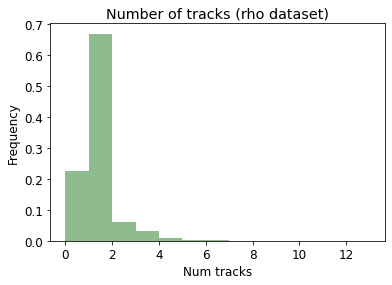

num events: 5000
0 hits: 0.2252
1 hits: 0.668
2+ hits: 0.1068


In [959]:
events_arr["nTrack"] = np.array(events_arr["nTrack"])
pu.plot_hist(events_arr["nTrack"], 13, "Number of tracks (rho dataset)", "Num tracks", "Frequency", True, "darkseagreen")

print("num events:", len(events_arr["nTrack"]))
print("0 hits:", len(events_arr["nTrack"][events_arr["nTrack"] == 0])/len(events_arr["nTrack"]))
print("1 hits:", len(events_arr["nTrack"][events_arr["nTrack"] == 1])/len(events_arr["nTrack"]))
print("2+ hits:", len(events_arr["nTrack"][events_arr["nTrack"] >= 2])/len(events_arr["nTrack"]))


In [209]:
# MIXED
# data variables
LOG_ENERGY_MEAN = -1 # unrounded mean is ~ 0.93
MASK_OUT = -1
THRESHOLD_EM_FRAC = 0.7869926# 0.94810295#
LOG_MEAN_TRACK_MOMETUM = 4


# load and process pion file
pi0_file_num = 13
pipm1_file_num = 11
pipm2_file_num = 12
len_file = 6000
i_low = 0
i_high = 0
energy_threshold = 0
BATCH_SIZE = None
group_events = True
mixed = True
cut = False
rho = False
include_tracks = "all"
pion_dir = "/data/mjovanovic/train_testing_data/" + ("charged_" if not mixed else "") + "pion_files"

In [2]:
# CHARGED SMALLER TEST - for track data
# data variables
LOG_ENERGY_MEAN = -1 # unrounded mean is ~ 0.93
LOG_MEAN_TRACK_MOMETUM = 4
MASK_OUT = -1
THRESHOLD_EM_FRAC = 0.7869926# 0.94810295#

# load and process pion file
pi0_file_num = 0
pipm1_file_num = 17
pipm2_file_num = 0
len_file = 6000
i_low = 0
i_high = 0
energy_threshold = 0
BATCH_SIZE = None
group_events = True
mixed = False
rho = False
cut = False
new_format = True
include_tracks = True
left_from_include_tracks = False
pion_dir = "/data/mjovanovic/train_testing_data/" + ("charged_" if not mixed else "") + "pion_files"

In [3]:
# track metadata
calo_layers = ['EMB1', 'EMB2', 'EMB3', 'EME1', 'EME2', 'EME3', 'HEC0', 'HEC1',
    'HEC2', 'HEC3', 'TileBar0', 'TileBar1', 'TileBar2', 'TileGap1', 'TileGap2',
    'TileGap3', 'TileExt0', 'TileExt1', 'TileExt2']

NUM_TRACK_POINTS = len(calo_layers)

has_fixed_r = {
    'EMB1': True,
    'EMB2': True,
    'EMB3': True,
    'EME1': False,
    'EME2': False,
    'EME3': False,
    'HEC0': False,
    'HEC1': False,
    'HEC2': False,
    'HEC3': False,
    'TileBar0': True,
    'TileBar1': True,
    'TileBar2': True,
    'TileGap1': True,
    'TileGap2': True,
    'TileGap3': True,
    'TileExt0': True,
    'TileExt1': True,
    'TileExt2': True
}

fixed_r = {
    'EMB1': 1532.18,
    'EMB2': 1723.89,
    'EMB3': 1923.02,
    'TileBar0': 2450.00,
    'TileBar1': 2995.00,
    'TileBar2': 3630.00,
    'TileGap1': 3215.00,
    'TileGap2': 3630.00,
    'TileGap3': 2246.50,
    'TileExt0': 2450.00,
    'TileExt1': 2870.00,
    'TileExt2': 3480.00
}

fixed_z = {
    'EME1': 3790.03,
    'EME2': 3983.68,
    'EME3': 4195.84,
    'HEC0': 4461.25,
    'HEC1': 4869.50,
    'HEC2': 5424.50,
    'HEC3': 5905.00,
}

In [4]:
def spherical_to_cartesian(rs, phis, thetas):
    # convert to x, y, z
    x, y, z = [], [], []

    for i, r in enumerate(rs):
        x.append(r*np.cos(phis[i]))
        y.append(r*np.sin(phis[i]))
        z.append( r/np.tan(thetas[i]))

    return np.array(x), np.array(y), np.array(z)


print("mixed:", mixed)
# load cell geo tree dict
file = uproot.open("/data/atlas/data/rho_delta/rho_small.root")
cell_geo_tree = file["CellGeo"]

node_feature_names = cell_geo_tree.keys()[1:7] # 'cell_geo_sampling', 'cell_geo_eta', 'cell_geo_phi', 'cell_geo_rPerp', 'cell_geo_deta', 'cell_geo_dphi'

if mixed:
    file_names = ["/pi0_" + str(pi0_file_num) + "_pipm_" + str(pipm1_file_num) + "_" + str(pipm2_file_num) + "_len_" + str(len_file) + "_i_" + str(i) + ".npy" for i in range(i_low, i_high + 1)]
elif rho:
    file_names = ["one file"]
elif new_format:
    file_names = list(map(lambda i:  "/pipm_" + str(pipm1_file_num) + "_len_" + str(len_file) + "_i_" + str(i) + ".npy", np.arange(i_low, i_high + 1)))
else:
    file_names = ["/pipm_" + str(pipm1_file_num) + "_" + str(pipm2_file_num) + "_" + str(pi0_file_num) + "_len_" + str(len_file) + "_i_" + str(i) + ".npy" for i in range(i_low, i_high + 1)]

print(file_names)
cell_geo_data = cell_geo_tree.arrays(library='np')
cell_geo_ID = cell_geo_data['cell_geo_ID'][0]
sorter = np.argsort(cell_geo_ID)

# cluster data dict to look up data by feature name
processed_event_data = {}
processed_event_track_data = {}


cell_geo_ID = cell_geo_data['cell_geo_ID'][0]

for feature in [*node_feature_names, 'x', 'y', 'z', 'truth_EM_frac', 'cluster_cell_E', 'truth_particle', 'truth_EM_frac_class', 'cluster_E', 'cluster_Pt', 'nTracks']:
    processed_event_data[feature] = []

for feature in ['x', 'y', 'z', 'P', 'track_bool']:
    processed_event_track_data[feature] = []

samples_count = 0

tot_event = 0
for file_name in file_names:
    if rho:
        event_data = uproot.open("/data/atlas/data/rho_delta/rho_small.root:EventTree").arrays(library="np")
    else:
        event_data = np.load(pion_dir + file_name, allow_pickle=True).item()

    num_events = len(event_data["eventNumber"])
    num_cells = 0

    for event_idx in range(num_events):
        num_clusters = event_data["nCluster"][event_idx]
        num_tracks = event_data["nTrack"][event_idx]
        if num_clusters != 0:
            processed_event_data['nTracks'].append(num_tracks)

        if (left_from_include_tracks and num_tracks != 1) or (not include_tracks and not left_from_include_tracks) or (include_tracks and num_tracks == 1):
            if include_tracks:
                if num_tracks == 1:
                    # get track info
                    # considering 6 track hits, one in each section of calorimeter
                    etas = []
                    phis = []
                    rPerps = []
                    # get the eta, phi, and rPerp of each layers hit
                    for layer_name in calo_layers:
                        if has_fixed_r[layer_name]:
                            etas.append(event_data['trackEta_' + layer_name][event_idx][0])
                            phis.append(event_data['trackPhi_' + layer_name][event_idx][0])
                            rPerps.append(fixed_r[layer_name])
                        else:
                            eta = event_data['trackEta_' + layer_name][event_idx][0]
                            etas.append(eta)
                            phis.append(event_data['trackPhi_' + layer_name][event_idx][0])
                            
                            z = fixed_z[layer_name]
                            aeta = np.abs(eta)
                            rPerp = z*2*np.exp(aeta)/(np.exp(2*aeta) - 1)
                            rPerps.append(rPerp)
                    
                    # convert each hit to the cartesian coords
                    thetas = [2*np.arctan(np.exp(-eta)) for eta in etas]
                    x_tracks, y_tracks, z_tracks = spherical_to_cartesian(rPerps, phis, thetas)

                    non_null_tracks = np.full(NUM_TRACK_POINTS, True)

                    # if eta > 4.9 or phi > pi mark the track as null (why??)
                    non_null_tracks[(np.abs(etas) >= 2.5) | (np.abs(phis) > np.pi)] = False
                else:
                    non_null_tracks = np.full(NUM_TRACK_POINTS, 0)
                    x_tracks, y_tracks, z_tracks = np.zeros(NUM_TRACK_POINTS), np.zeros(NUM_TRACK_POINTS), np.zeros(NUM_TRACK_POINTS)

            # Only keep event if there is at least one track hit
            if not include_tracks or np.count_nonzero(non_null_tracks) != 0:
                for cluster_idx in range(num_clusters):
                    cell_IDs = event_data['cluster_cell_ID'][event_idx][cluster_idx]

                    # get truth enery (EM/nonEM)
                    cell_hits_E_EM = np.array(event_data["cluster_cell_hitsE_EM"][event_idx][cluster_idx])
                    cell_hits_E_non_EM = np.array(event_data["cluster_cell_hitsE_nonEM"][event_idx][cluster_idx])
                    cell_hits_E = cell_hits_E_EM + cell_hits_E_non_EM

                    # filter out cells with truth energy of 0
                    threshold_E = cell_hits_E > energy_threshold
                    
                    cell_IDs = cell_IDs[threshold_E]
                    num_cells_in_clus = len(cell_IDs)
                    num_cells += num_cells_in_clus
                    cell_ID_map = sorter[np.searchsorted(cell_geo_ID, cell_IDs, sorter=sorter)]

                    # get truth energy fraction EM/EM + nonEM for each cell
                    truth_EM_frac = cell_hits_E_EM[threshold_E] / cell_hits_E[threshold_E]

                    # classify truth_EM_frac
                    truth_EM_frac_class = [0 if truth_EM_frac_i <= THRESHOLD_EM_FRAC else 1 for truth_EM_frac_i in truth_EM_frac] # YES it is classifying the data !!! jus not naming the files - classify

                    # get cluster cell energy
                    cluster_cell_E = event_data["cluster_cell_E"][event_idx][cluster_idx][threshold_E]

                    # node features
                    node_features = {}
                    for feature in node_feature_names:
                        node_features[feature] = cell_geo_data[feature][0][cell_ID_map]

                    # get cartesian coords
                    thetas = [2*np.arctan(np.exp(-eta)) for eta in node_features["cell_geo_eta"]]
                    x, y, z = spherical_to_cartesian(node_features["cell_geo_rPerp"], node_features["cell_geo_phi"], thetas)

                    # get target particle - 0 for pi0 [111], 1 for pi+/- [-111]
                    truth_particle = 0 if event_data["truthPartPdgId"][event_idx][0] == 111 else 1

                    cluster_Pt = event_data["cluster_Pt"][event_idx][cluster_idx]
                    cluster_E = event_data["cluster_E"][event_idx][cluster_idx]

                    # if grouped by events extend the set of event points with the clusters points
                    if group_events and num_cells_in_clus != 0:
                        # append empty array for all cells in an event
                        if len(processed_event_data["cluster_cell_E"]) == samples_count:
                            for feature in [*node_feature_names, 'x', 'y', 'z', 'truth_EM_frac', 'cluster_cell_E', 'truth_particle', 'truth_EM_frac_class', 'cluster_Pt', 'cluster_E']:
                                processed_event_data[feature].append([])

                        processed_event_data["truth_EM_frac"][samples_count].append(truth_EM_frac)
                        processed_event_data["truth_EM_frac_class"][samples_count].append(truth_EM_frac_class)
                        processed_event_data["cluster_cell_E"][samples_count].append(cluster_cell_E)
                        processed_event_data["truth_particle"][samples_count].append(truth_particle)
                        processed_event_data["cluster_Pt"][samples_count].append(cluster_Pt)
                        processed_event_data["cluster_E"][samples_count].append(cluster_E)


                        for feature in node_feature_names:
                            processed_event_data[feature][samples_count].append(node_features[feature])

                        processed_event_data["x"][samples_count].append(x)
                        processed_event_data["y"][samples_count].append(y)
                        processed_event_data["z"][samples_count].append(z)

                    # if grouped by clusters append the set of clusters points
                    elif num_cells_in_clus != 0: # not used for analysis yet - update later
                        processed_event_data["truth_EM_frac"].append(truth_EM_frac)
                        processed_event_data["truth_EM_frac_class"].append(truth_EM_frac_class)
                        processed_event_data["cluster_cell_E"].append(cluster_cell_E)
                        processed_event_data["truth_particle"].append(truth_particle)

                        for feature in node_feature_names:
                            processed_event_data[feature].append(node_features[feature])

                        processed_event_data["x"].append(x)
                        processed_event_data["y"].append(y)
                        processed_event_data["z"].append(z)
                        
                        samples_count += 1
                        num_cells = 0
                    
                if group_events and num_cells > 0:      
                    if include_tracks:            
                        if num_tracks == 1:
                            # get tracks momentum readout
                            trackP = np.log10(event_data['trackP'][event_idx][0]) - LOG_MEAN_TRACK_MOMETUM
                            num_tracks = np.sum(non_null_tracks)
                            trackPs = np.full(NUM_TRACK_POINTS, trackP)
                        else:
                            trackPs = np.full(NUM_TRACK_POINTS, 0)
                        
                        # zero out all values in null tracks
                        x_tracks[~non_null_tracks] = 0
                        y_tracks[~non_null_tracks] = 0
                        z_tracks[~non_null_tracks] = 0
                        trackPs[~non_null_tracks] = 0

                        processed_event_track_data["x"].append(x_tracks)
                        processed_event_track_data["y"].append(y_tracks)
                        processed_event_track_data["z"].append(z_tracks)
                        processed_event_track_data["P"].append(trackPs)
                        processed_event_track_data["track_bool"].append(non_null_tracks)

                    # update event counter and max cells/event tracking
                    samples_count += 1
                    num_cells = 0
    
    if BATCH_SIZE:
        # filter to BS multiple num samples/files - to make set even with preds from a trained model
        BS_multiple_num_samples = math.floor(samples_count / BATCH_SIZE)*BATCH_SIZE
        print("BS_multiple_num_samples", BS_multiple_num_samples)
        print("samples_count", samples_count)
        if BS_multiple_num_samples == samples_count:
            BS_multiple_num_samples -= BATCH_SIZE
        for key in processed_event_data:
            del processed_event_data[key][BS_multiple_num_samples - samples_count:]
        print("num dropped events:", samples_count - BS_multiple_num_samples)
        samples_count = BS_multiple_num_samples
    
    print("num events in file:", samples_count)


if cut:
    print("start cut")
    dropped_events = 0
    for i, keep_event in enumerate(keep_events):
        if not keep_event:
            for key in processed_event_data:
                del processed_event_data[key][i + dropped_events]
            dropped_events -= 1
    

mixed: False
['/pipm_17_len_6000_i_0.npy']


/tmp/ipykernel_49071/3196021705.py:86: RuntimeWarning: overflow encountered in exp
  rPerp = z*2*np.exp(aeta)/(np.exp(2*aeta) - 1)
/tmp/ipykernel_49071/3196021705.py:86: RuntimeWarning: invalid value encountered in double_scalars
  rPerp = z*2*np.exp(aeta)/(np.exp(2*aeta) - 1)
/tmp/ipykernel_49071/3196021705.py:90: RuntimeWarning: overflow encountered in exp
  thetas = [2*np.arctan(np.exp(-eta)) for eta in etas]


num events in file: 3069


In [5]:
def flatten_event_to_cells(event):
    return np.array([cell for clus in event for cell in clus])

def flatten_events_and_clus_to_events(events_data):
    return [[cell_data for clus_data in event_data for cell_data in clus_data] for event_data in events_data]

def flatten_events_to_clus(events_data):
    return np.array([clus_data for event_data in events_data for clus_data in event_data])

def flatten_one_layer(data):
    return np.array([data_layer2 for data_layer1 in data for data_layer2 in data_layer1])

def flatten_events_to_cells(events_data):
    return [cell_data for clus_data in flatten_events_to_clus(events_data) for cell_data in clus_data]

Missing projection track analysis

In [1125]:
def plot_hist(data, bins, title, x_label, y_label, normalize=True, colour=None, xlim=None):
    counts, bins = np.histogram(data, bins, (0, 10))
    print(bins)
    print(counts)
    # normalize counts
    if normalize:
        counts = counts / np.sum(counts)
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.hist(bins[:-1], bins, weights=counts, color=colour, align="mid")
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xlim(xlim)
    plt.show()

frac with padded projections: 0.0
frac with track: 1.0
frac with track but missing projections: 0.0


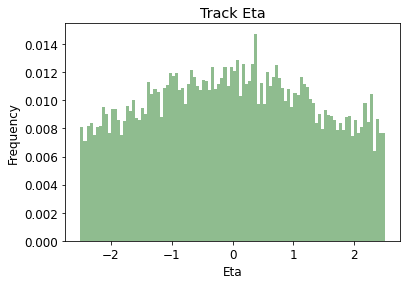

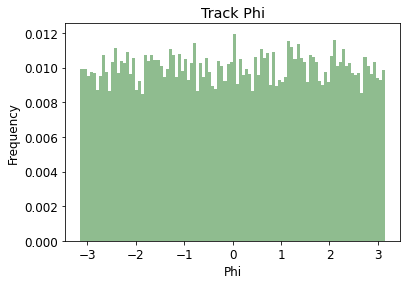

num at: 0 -- 0
num at: 1 -- 0
num at: 2 -- 3
num at: 3 -- 21
num at: 4 -- 60
num at: 5 -- 429
num at: 6 -- 8098
num at: 7 -- 8465
num at: 8 -- 1029
num at: 9 -- 210
num at: 10 -- 0
num at: 11 -- 0
num at: 12 -- 0
num at: 13 -- 0
num at: 14 -- 0
num at: 15 -- 0
num at: 16 -- 0
num at: 17 -- 0
num at: 18 -- 0
num at: 19 -- 0
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
[   0    0    3   21   60  429 8098 8465 1029  210]


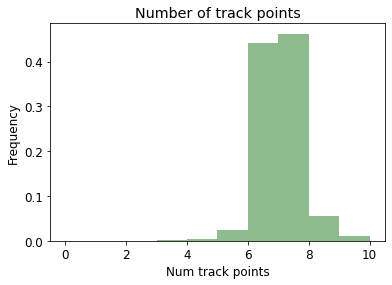

In [1147]:
num_events = len(processed_event_track_data["is_track"])
padded_projections = np.array([np.count_nonzero(track_bools) == 0 for track_bools in processed_event_track_data["is_track"]])
has_track = np.array(processed_event_track_data["track_eta"]) != 0
print("frac with padded projections:", np.count_nonzero(padded_projections) / num_events)
print("frac with track:", np.count_nonzero(has_track) / num_events)
print("frac with track but missing projections:", np.count_nonzero(has_track & padded_projections) / num_events)

processed_event_track_data["track_eta"] = np.array(processed_event_track_data["track_eta"])
processed_event_track_data["track_phi"] = np.array(processed_event_track_data["track_phi"])
pu.plot_hist(processed_event_track_data["track_eta"][has_track & ~padded_projections], 100, "Track Eta", "Eta", "Frequency", colour="darkseagreen")
pu.plot_hist(processed_event_track_data["track_phi"][has_track & ~padded_projections], 100, "Track Phi", "Phi", "Frequency", colour="darkseagreen")

# plot distribuion of num track points
num_track_points = np.array([np.count_nonzero(track_bools) for track_bools in processed_event_track_data["is_track"]])
for i in range(20):
    print("num at:", i, "--",len(num_track_points[num_track_points == i]))

plot_hist(num_track_points, 10, "Number of track points", "Num track points", "Frequency", colour="darkseagreen", xlim=(-0.5, 10.5))


1 track after cut: 0.0


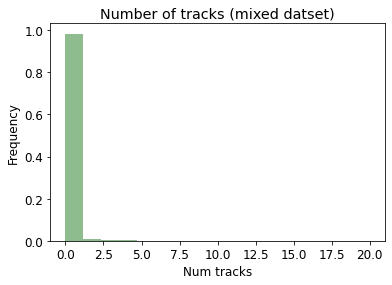

num events: 36000
0 tracks: 0.3799166666666667
1 track: 0.6036944444444444
2+ tracks: 0.01638888888888889


In [1032]:
# num tracks
num_tracks_list = np.array(num_tracks_list)

print("1 track after cut:", num_with_track_after_cut / len(num_tracks_list))
pu.plot_hist(num_tracks_list, 17, "Number of tracks (mixed datset)", "Num tracks", "Frequency", True, "darkseagreen")

print("num events:", len(num_tracks_list))
print("0 tracks:", len(num_tracks_list[num_tracks_list == 0])/len(num_tracks_list))
print("1 track:", len(num_tracks_list[num_tracks_list == 1])/len(num_tracks_list))
print("2+ tracks:", len(num_tracks_list[num_tracks_list >= 2])/len(num_tracks_list))

In [968]:
print(np.mean(np.log10(energies)))

2.4050632518991644


num cells: 65


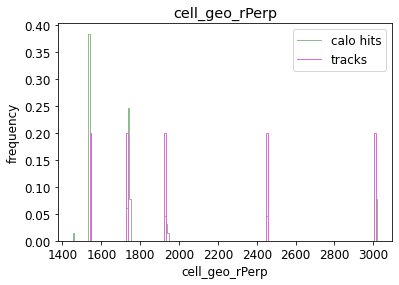

num track hits: 6
track hits z: [ 834.78502097  939.40471727 1046.19459397 1328.07274704 1631.48088789
 1966.81854782]


/tmp/ipykernel_22601/3670109734.py:25: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


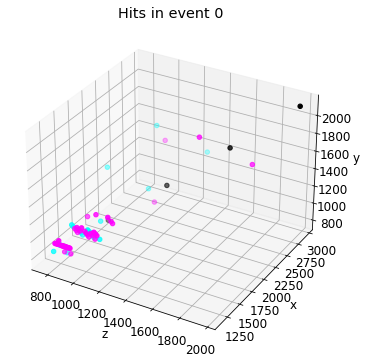

num cells: 298


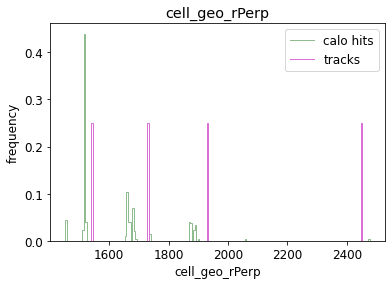

num track hits: 3
track hits z: [2409.89625491 2711.91572063 3020.19426039]


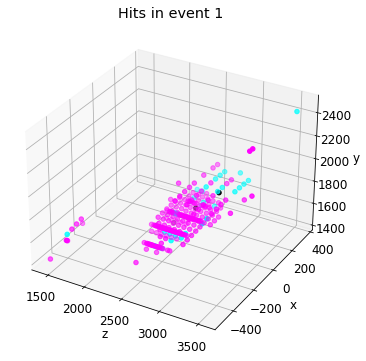

num cells: 126


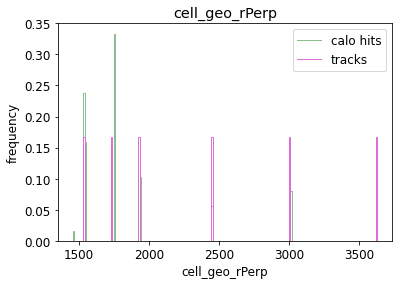

num track hits: 6
track hits z: [306.34857793 344.74225829 383.9320349  487.38214986 599.01580585
 723.47681613]


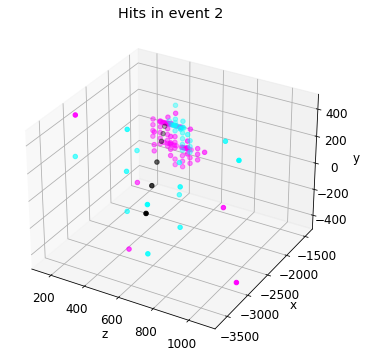

num events with no track hits: 0 out of 1376
frac: 0.0


In [696]:
event_idxs = np.arange(3) # [10, 12]
show_em_frac = True

for event_idx in event_idxs:
    key = "cell_geo_rPerp"
    print("num cells:", len(flatten_event_to_cells(processed_event_data[key][event_idx])))
    pu.plot_overlay_hist([flatten_event_to_cells(processed_event_data[key][event_idx]), rPerps], 200, key, key, "frequency", ["calo hits", "tracks"], colours=['darkseagreen', 'orchid'])

    calo_hits_x = flatten_event_to_cells(processed_event_data["x"][event_idx])
    calo_hits_y = flatten_event_to_cells(processed_event_data["y"][event_idx])
    calo_hits_z = flatten_event_to_cells(processed_event_data["z"][event_idx])
    em_frac = flatten_event_to_cells(processed_event_data["truth_EM_frac_class"][event_idx])

    track_hits_x = processed_event_track_data["x"][event_idx]
    track_hits_x = track_hits_x[track_hits_x != 0]
    track_hits_y = processed_event_track_data["y"][event_idx]
    track_hits_y = track_hits_y[track_hits_y != 0]
    track_hits_z = processed_event_track_data["z"][event_idx]
    track_hits_z = track_hits_z[track_hits_z != 0]

    print("num track hits:", len(track_hits_z[track_hits_z != 0]))
    print("track hits z:", track_hits_z)
    fig = plt.figure(figsize=(6,6))
    fig.patch.set_facecolor('white')
    ax = fig.gca(projection='3d')
    if show_em_frac:
        cut_em_class = em_frac == 1
        ax.scatter(calo_hits_z[cut_em_class], calo_hits_x[cut_em_class], calo_hits_y[cut_em_class], color="fuchsia")
        ax.scatter(calo_hits_z[~cut_em_class], calo_hits_x[~cut_em_class], calo_hits_y[~cut_em_class], color="cyan")  
    #ax.scatter(calo_hits_z, calo_hits_x, calo_hits_y, color="pink")
    ax.scatter(track_hits_z, track_hits_x, track_hits_y, color="black")
    ax.set_xlabel("z")
    ax.set_ylabel("x")
    ax.set_zlabel("y")
    plt.title("Hits in event " + str(event_idx))
    plt.show()

print("num events with no track hits:", sum([not np.any(event_track_x) for event_track_x in processed_event_track_data["x"]]), "out of", len(processed_event_track_data["x"]))
print("frac:", sum([not np.any(event_track_x) for event_track_x in processed_event_track_data["x"]])/len(processed_event_track_data["x"]))

1 track after cut: 0.2628666666666667


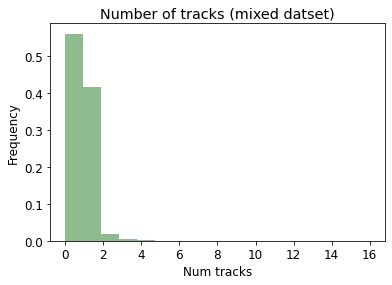

num events: 30000
0 tracks: 0.5596
1 track: 0.4145
2+ tracks: 0.0259


In [1005]:
# num tracks
num_tracks_list = np.array(num_tracks_list)

print("1 track after cut:", num_with_track_after_cut / len(num_tracks_list))
pu.plot_hist(num_tracks_list, 17, "Number of tracks (mixed datset)", "Num tracks", "Frequency", True, "darkseagreen")

print("num events:", len(num_tracks_list))
print("0 tracks:", len(num_tracks_list[num_tracks_list == 0])/len(num_tracks_list))
print("1 track:", len(num_tracks_list[num_tracks_list == 1])/len(num_tracks_list))
print("2+ tracks:", len(num_tracks_list[num_tracks_list >= 2])/len(num_tracks_list))

In [306]:
# filter calo hits by proximity to a track point
# get min points min dist to track
largest_num = 13500
x = [(np.array(event_x) - (-3626)) / (3626 - (-3626)) for event_x in flatten_events_and_clus_to_events(processed_event_data["x"])]
y = [(np.array(event_y) - (-3626)) / (3626 - (-3626)) for event_y in flatten_events_and_clus_to_events(processed_event_data["y"])]
z = [(np.array(event_z) - (-5906)) / (5906 - (-5906)) for event_z in flatten_events_and_clus_to_events(processed_event_data["z"])]



min_dists = []
for event_idx, x_i in enumerate(x):
    dists = np.zeros((len(x_i), len(processed_event_track_data["x"][event_idx][processed_event_track_data["is_track"][event_idx] == 1])))
    
    save_track_idx = 0
    for track_idx, track_x_i in enumerate(processed_event_track_data["x"][event_idx]):
        if processed_event_track_data["is_track"][event_idx][track_idx]:
            dists[:len(x_i), save_track_idx] = np.sqrt((x_i - track_x_i)**2 + (y[event_idx] - processed_event_track_data["y"][event_idx][track_idx])**2 + (z[event_idx] - processed_event_track_data["z"][event_idx][track_idx])**2)
            save_track_idx += 1 
    min_dists.extend(np.min(dists, axis=1))

print(len(min_dists))
    
min_dists = np.array(min_dists)
print(len(min_dists[min_dists == largest_num])/len(min_dists))

pu.plot_hist(min_dists, 100, "Minimum distance to track point", "Min dist", "Frequency", colour="mediumorchid")


ValueError: zero-size array to reduction operation minimum which has no identity

3463076
[False False False ...  True  True  True]
1689991
1773085


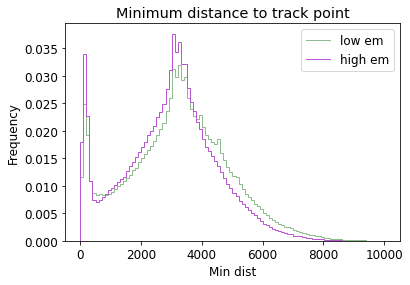

In [829]:
cut_low_em_class = np.array(flatten_events_to_cells(processed_event_data["truth_EM_frac_class"])) == 0
print(len(min_dists))
print(cut_low_em_class)
print(len(min_dists[~cut_low_em_class]))
print(len(min_dists[cut_low_em_class]))
pu.plot_overlay_hist([min_dists[cut_low_em_class], min_dists[~cut_low_em_class]], 100, "Minimum distance to track point", "Min dist", "Frequency", ["low em", "high em"], colours=["darkseagreen", "mediumorchid"])



frac not padding: 0.3460489680279752


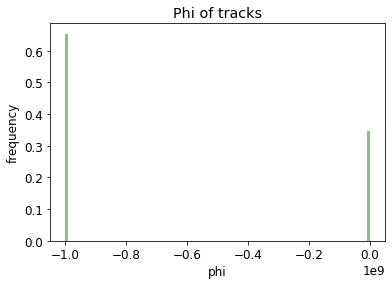

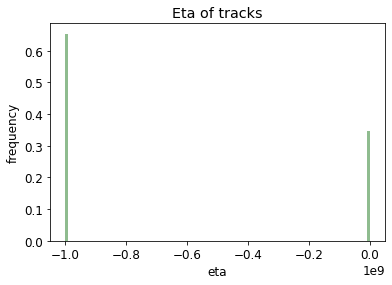

/home/mjovanovic/Work/LCStudies/data/particle_data_visualize_plot_utils.py:16: RuntimeWarning: invalid value encountered in divide
  counts = counts / np.sum(counts)


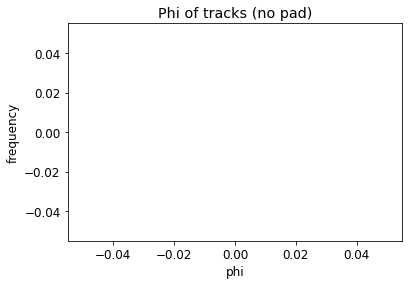

min: -3.1415193
max: 3.141571


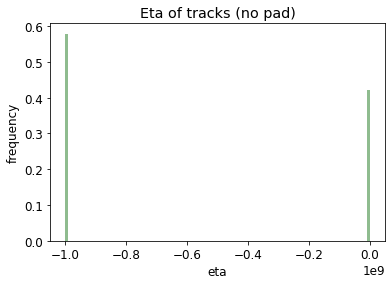

min: -1000000000.0
max: 1.4301761


In [1128]:
processed_event_track_data["phi"] = np.array(processed_event_track_data["phi"])
print("frac not padding:", len(processed_event_track_data["phi"][processed_event_track_data["phi"] != -1e9]) / len(flatten_event_to_cells(processed_event_track_data["phi"])))

pu.plot_hist(processed_event_track_data["phi"], 100, "Phi of tracks", "phi", "frequency", colour="darkseagreen")
pu.plot_hist(processed_event_track_data["eta"], 100, "Eta of tracks", "eta", "frequency", colour="darkseagreen")

pu.plot_hist(processed_event_track_data["phi"][processed_event_track_data["is_track"] == 1], 100, "Phi of tracks (no pad)", "phi", "frequency", colour="darkseagreen")
print("min:", np.min(processed_event_track_data["phi"][processed_event_track_data["phi"] != -1e9]))
print("max:", np.max(processed_event_track_data["phi"][processed_event_track_data["phi"] != -1e9]))

pu.plot_hist(processed_event_track_data["eta"][processed_event_track_data["is_track"] != 0], 100, "Eta of tracks (no pad)", "eta", "frequency", colour="darkseagreen")
print("min:", np.min(processed_event_track_data["eta"][processed_event_track_data["eta"] != -1e9]))
print("max:", np.max(processed_event_track_data["eta"][processed_event_track_data["eta"] != -1e9]))

347985
347985
[   0.            0.            0.         1264.49322253 1329.07639523
 1399.83176374 1488.36371332    0.            0.            0.        ]
[False False False  True  True  True  True False False False]
227566
[False False False ... False False False]
mean log10(momentum): 1.9306456


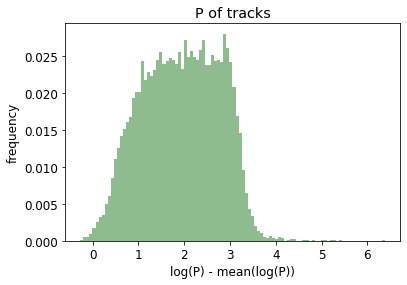

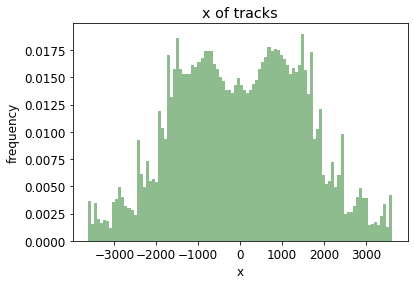

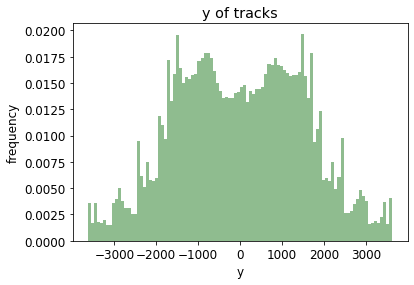

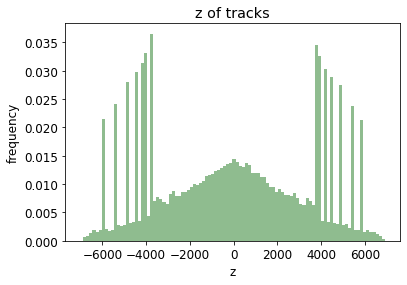

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


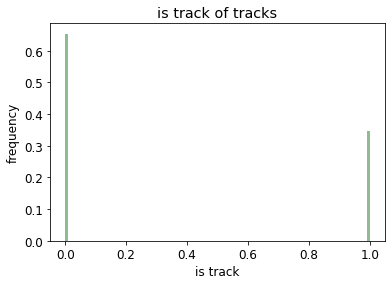

In [1148]:
P = np.array(flatten_event_to_cells(processed_event_track_data["P"]))
x = np.array(flatten_event_to_cells(processed_event_track_data["x"]))
y = np.array(flatten_event_to_cells(processed_event_track_data["y"]))
z = np.array(flatten_event_to_cells(processed_event_track_data["z"]))
is_track = np.array(flatten_event_to_cells(processed_event_track_data["is_track"]))

print(len(x))
print(len(is_track))
print(x[:10])
print(is_track[:10])

print(len(x[x == 0]))

cut_tracks = x != 0
print(cut_tracks)

print("mean log10(momentum):", np.mean(P[cut_tracks]))
pu.plot_hist(P[cut_tracks], 100, "P of tracks", "log(P) - mean(log(P))", "frequency", colour="darkseagreen")
pu.plot_hist(x[cut_tracks], 100, "x of tracks", "x", "frequency", colour="darkseagreen")
pu.plot_hist(y[cut_tracks], 100, "y of tracks", "y", "frequency", colour="darkseagreen")
pu.plot_hist(z[cut_tracks], 100, "z of tracks", "z", "frequency", colour="darkseagreen")
pu.plot_hist(cut_tracks, 100, "is track of tracks", "is track", "frequency", colour="darkseagreen")

In [320]:
file_name = "/data/mjovanovic/train_testing_data/charged_pion_files/pipm_17_len_6000_i_0.npy"
weight_cells = False

event_data = np.load(file_name, allow_pickle=True).item()

num_events = len(event_data["eventNumber"])

# cluster data dict to look up data by feature name
processed_event_data = {}
processed_event_track_data = {}
processed_event_track_flags = []

cell_geo_ID = cell_geo_data['cell_geo_ID'][0]

samples_count = 0
max_cells = 0
num_cells = 0

for feature in [*node_feature_names, 'x', 'y', 'z', 'truth_EM_frac', 'cluster_cell_E', 'cluster_cell_E_weight', 'nTracks']:
    processed_event_data[feature] = []

for feature in ['x', 'y', 'z', 'P', 'track_bool']:
    processed_event_track_data[feature] = []

for event_idx in range(num_events):
    num_clusters = event_data["nCluster"][event_idx]
    num_tracks = event_data["nTrack"][event_idx]

    if num_tracks == 1:
        # get track info
        # considering 6 track hits, one in each section of calorimeter
        layer_names = ['EMB1', 'EMB2', 'EMB3', 'TileBar0', 'TileBar1', 'TileBar2']
        rPerps = np.array([1540., 1733., 1930., 2450., 3010., 3630.])
        etas = []
        phis = []
        # get the eta and phi of each layers hit
        for layer_name in layer_names:
            etas.append(event_data['trackEta_' + layer_name][event_idx][0])
            phis.append(event_data['trackPhi_' + layer_name][event_idx][0])
        
        # convert each hit to the cartesian coords
        thetas = [2*np.arctan(np.exp(-eta)) for eta in etas]
        x_tracks, y_tracks, z_tracks = spherical_to_cartesian(rPerps, phis, thetas)

        non_null_tracks = np.full(6, 1)

        # if eta > 4.9 or phi > pi mark the track as null (why??)
        non_null_tracks[(np.abs(etas) > 4.9) | (np.abs(phis) >= np.pi)] = False

        # Only keep event if there is at least one track hit
        if np.any(non_null_tracks):
            # append empty array for all cells in an event
            if group_events:
                for feature in [*node_feature_names, 'x', 'y', 'z', 'truth_EM_frac', 'cluster_cell_E', 'cluster_cell_E_weight']:
                    processed_event_data[feature].append([])

            for cluster_idx in range(num_clusters):
                cell_IDs = event_data['cluster_cell_ID'][event_idx][cluster_idx]

                # get truth enery (EM/nonEM)
                cell_hits_E_EM = np.array(event_data["cluster_cell_hitsE_EM"][event_idx][cluster_idx])
                cell_hits_E_non_EM = np.array(event_data["cluster_cell_hitsE_nonEM"][event_idx][cluster_idx])
                cell_hits_E = cell_hits_E_EM + cell_hits_E_non_EM

                # filter out cells with truth energy of 0
                threshold_E = cell_hits_E > energy_threshold
                
                cell_IDs = cell_IDs[threshold_E]
                num_cells += len(cell_IDs)
                cell_ID_map = sorter[np.searchsorted(cell_geo_ID, cell_IDs, sorter=sorter)]

                # get truth energy fraction EM/EM + nonEM for each cell
                truth_EM_frac = cell_hits_E_EM[threshold_E] / cell_hits_E[threshold_E]

                # classify truth_EM_frac
                truth_EM_frac = [0 if truth_EM_frac_i <= THRESHOLD_EM_FRAC else 1 for truth_EM_frac_i in truth_EM_frac]

                # get cluster cell energy
                cluster_cell_E = event_data["cluster_cell_E"][event_idx][cluster_idx][threshold_E]
                cluster_cell_E_weight = cluster_cell_E / np.sum(cluster_cell_E)
                cluster_cell_E = np.log10(cluster_cell_E) - LOG_ENERGY_MEAN

                # node features
                node_features = {}
                for feature in node_feature_names:
                    node_features[feature] = cell_geo_data[feature][0][cell_ID_map]

                # get cartesian coords
                thetas = [2*np.arctan(np.exp(-eta)) for eta in node_features["cell_geo_eta"]]
                x, y, z = spherical_to_cartesian(node_features["cell_geo_rPerp"], node_features["cell_geo_phi"], thetas)

                # if grouped by events extend the set of event points with the clusters points
                if group_events and num_cells != 0:
                    processed_event_data["truth_EM_frac"][samples_count].extend(truth_EM_frac)
                    processed_event_data["cluster_cell_E"][samples_count].extend(cluster_cell_E)
                    processed_event_data["cluster_cell_E_weight"][samples_count].extend(cluster_cell_E_weight)

                    for feature in node_feature_names:
                        processed_event_data[feature][samples_count].extend(node_features[feature])

                    processed_event_data["x"][samples_count].extend(x)
                    processed_event_data["y"][samples_count].extend(y)
                    processed_event_data["z"][samples_count].extend(z)

                # if grouped by clusters append the set of clusters points
                elif num_cells != 0:
                    processed_event_data["truth_EM_frac"].append(truth_EM_frac)
                    processed_event_data["cluster_cell_E"].append(cluster_cell_E)
                    processed_event_data["cluster_cell_E_weight"].append(cluster_cell_E_weight)

                    for feature in node_feature_names:
                        processed_event_data[feature].append(node_features[feature])

                    processed_event_data["x"].append(x)
                    processed_event_data["y"].append(y)
                    processed_event_data["z"].append(z)
                    
                    samples_count += 1

                    if num_cells > max_cells:
                        max_cells = num_cells
                    num_cells = 0
            
            # event has non zero energy hits    
            if group_events and num_cells > 0:
                # get tracks momentum readout
                trackP = np.log(event_data['trackP'][event_idx][0]) - LOG_MEAN_TRACK_MOMETUM
                num_tracks = np.sum(non_null_tracks)
                trackPs = np.full(6, trackP)
                
                # zero out all values in null tracks
                x_tracks[~non_null_tracks] = 0
                y_tracks[~non_null_tracks] = 0
                z_tracks[~non_null_tracks] = 0
                trackPs[~non_null_tracks] = 0

                processed_event_track_data["x"].append(x_tracks)
                processed_event_track_data["y"].append(y_tracks)
                processed_event_track_data["z"].append(z_tracks)
                processed_event_track_data["P"].append(trackPs)
                processed_event_track_data["track_bool"].append(non_null_tracks)
                processed_event_track_flags.append(np.zeros(num_cells + 6))
                processed_event_track_flags[samples_count][-6:] = 1*(non_null_tracks)

                # update event counter and max cells/event tracking
                if num_cells > max_cells:
                    max_cells = num_cells
                samples_count += 1
                num_cells = 0

file_features = {'pion_pointnet_cartesian':['cluster_cell_E', 'x', 'y', 'z']}
for file_type in file_features:
    if include_tracks:
        point_data = np.zeros((samples_count, max_cells + 6, len(file_features[file_type]) + 1)) # pad X data with 0's
    else:
        point_data = np.zeros((samples_count, max_cells, len(file_features[file_type]))) # pad X data with 0's

    if weight_cells:
        label_len = 2
    else:
        label_len = 1
    if include_tracks:
        point_label = np.negative(np.ones((samples_count, max_cells + 6, label_len))) # pad Y data with -1's, since some EM fracs are 0
    else:
        point_label = np.negative(np.ones((samples_count, max_cells, label_len))) # pad Y data with -1's, since some EM fracs are 0


    for idx in range(samples_count):
        #print("idx:", idx)
        len_cluster = len(processed_event_data["cell_geo_eta"][idx])
        if(len_cluster == 0):
            print("zero len clus!!!")

        if include_tracks:
            len_cluster += 6
            track_features = ["P", "x", "y", "z"]
            cluster_point_data = np.concatenate(([np.concatenate((processed_event_data[file_feature][idx], processed_event_track_data[track_features[i]][idx]), -1)  for i, file_feature in enumerate(file_features[file_type])], [processed_event_track_flags[idx]]), 0)
        else:
            cluster_point_data = [processed_event_data[file_feature][idx] for file_feature in file_features[file_type]]

        point_data[idx, :len_cluster] = np.transpose(cluster_point_data)
        if weight_cells:
            point_label[idx, :len_cluster] = np.transpose([processed_event_data["truth_EM_frac"][idx], processed_event_data["cluster_cell_E_weight"][idx]])
        else:
            if include_tracks:
                point_label[idx, :len_cluster] = np.transpose([np.concatenate((processed_event_data["truth_EM_frac"][idx], np.full(6, -1)))]) # label all tracks as -1
            else:
                point_label[idx, :len_cluster] = np.transpose([processed_event_data["truth_EM_frac"][idx]])

/tmp/ipykernel_59001/1477703821.py:42: RuntimeWarning: overflow encountered in exp
  thetas = [2*np.arctan(np.exp(-eta)) for eta in etas]


In [529]:
X = point_data
cluster_data = X
Y = point_label

In [774]:
print(Y_padded[Y_padded != -1].shape)
print(X_padded.shape)

(310519,)
(1976, 1267, 6)


In [796]:
max_num_points = 1267
add_momentum_ratio = False
add_min_track_dist = True
add_both = False
largest_dist = 13500
all_min_dists = []

point_net_data = np.load('/data/mjovanovic/train_testing_data/pointnet_train_classify/test_all_tracks/pipm_17_len_6000_i_15_cartesian_event_grouped_charged.npz')
cluster_data = point_net_data['X']
Y = point_net_data['Y']

tot_num_tracks = 0
print("num events:", len(cluster_data))
print("shape data:", cluster_data.shape)

# pad X data to have y dimension of max_num_points
if add_momentum_ratio or add_min_track_dist:
    X_padded = np.zeros((cluster_data.shape[0], max_num_points, cluster_data.shape[2] + 1))
elif add_both:
    X_padded = np.zeros((cluster_data.shape[0], max_num_points, cluster_data.shape[2] + 2))
else:
    X_padded = np.zeros((cluster_data.shape[0], max_num_points, cluster_data.shape[2]))
Y_padded = np.negative(np.ones(((cluster_data.shape[0], max_num_points, 1)))) # NOTE: update for weighted cells
for i, cluster in enumerate(cluster_data):
    if add_momentum_ratio or add_both:
        track_values = cluster[:,0][cluster[:,4] == 1]
        track_value = track_values[0] if np.any(track_values) else 0
        if track_value or add_both:
            X_padded[i, :len(cluster), 5] = X_padded[i, :len(cluster), 0] / track_value
    elif add_min_track_dist:
        track_points_idx = np.arange(len(cluster))[cluster[:, 4] == 1]
        dists = np.zeros((len(cluster), len(track_points_idx)))
        tot_num_tracks += len(track_points_idx)
        for j, track_point_idx in enumerate(track_points_idx):
            dists[:, j] = np.sqrt((cluster[:, 1] - cluster[track_point_idx, 1])**2 + (cluster[:, 2] - cluster[track_point_idx, 2])**2 + (cluster[:, 3] - cluster[track_point_idx, 3])**2)
        dist_feat_idx = 5
        if add_both:
            dist_feat_idx = 6

        if np.any(track_points_idx):
            min_dists = np.min(dists, axis=1)
            min_dists[(cluster[:, 4] == 0) & (Y[i, :, 0] == -1)] = -1
            X_padded[i, :len(cluster), dist_feat_idx] = min_dists
            all_min_dists.extend(min_dists)
        else:
            print("NO TRACK POINTS")
            X_padded[i, :len(cluster), dist_feat_idx] = 1e5

    X_padded[i, :len(cluster), :5] = cluster
    Y_padded[i, :len(cluster), :] = Y[i]



num events: 2027
shape data: (2027, 1130, 5)


5303.3985630288125
-1.0
2290510
num 0: 9729
num -1: 1950013
0.004247525660224142
tot num tracks: 9729


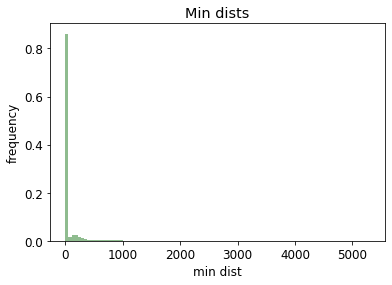

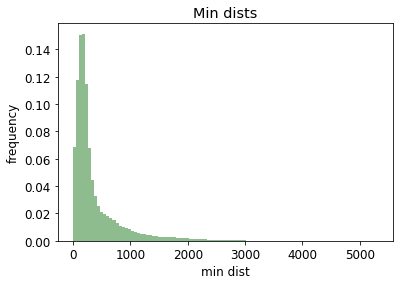

In [1001]:
all_min_dists = np.array(all_min_dists)
print(np.max(all_min_dists))
print(np.min(all_min_dists))
print(len(all_min_dists))
print("num 0:", len(all_min_dists[all_min_dists == 0]))
print("num -1:", len(all_min_dists[all_min_dists == -1]))
print(len(all_min_dists[all_min_dists == 0]) / len(all_min_dists))
print("tot num tracks:", tot_num_tracks)

pu.plot_hist(all_min_dists, 100, "Min dists", "min dist", "frequency", colour="darkseagreen")
pu.plot_hist(all_min_dists[all_min_dists != -1], 100, "Min dists", "min dist", "frequency", colour="darkseagreen")

num events: 2027
num expected track points: 9729.6
actual num track points: 9729
(2027, 1267)


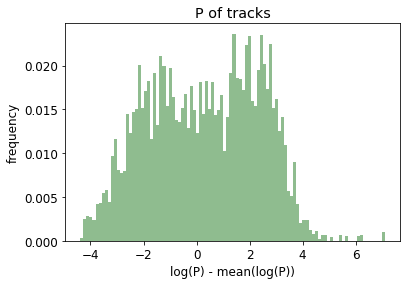

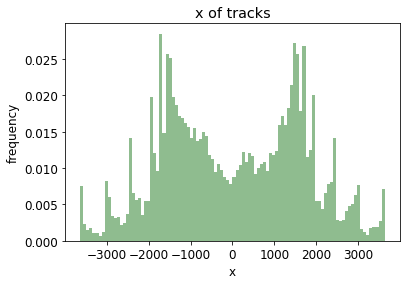

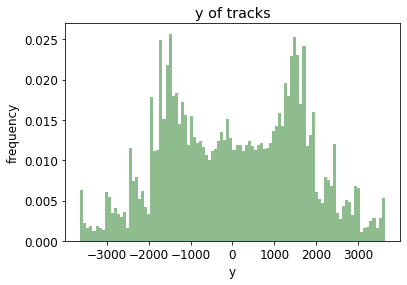

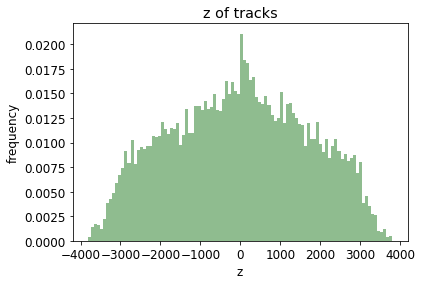

In [1000]:
print("num events:", len(Y_padded))
print("num expected track points:", 6*len(Y_padded)*0.8)
is_track = (X_padded[:,:,4] == 1)
print("actual num track points:", len(is_track[is_track]))
print(is_track.shape)

# get P,x,y,z for every track point in dataset
P = np.array(X_padded[:, :, 0][is_track & (X_padded[:, :, 1] != 0)]) # only cut points that are tracks and not padding
x = np.array(X_padded[:, :, 1][is_track & (X_padded[:, :, 1] != 0)])
y = np.array(X_padded[:, :, 2][is_track & (X_padded[:, :, 1] != 0)])
z = np.array(X_padded[:, :, 3][is_track & (X_padded[:, :, 1] != 0)])


pu.plot_hist(P, 100, "P of tracks", "log(P) - mean(log(P))", "frequency", colour="darkseagreen")
pu.plot_hist(x, 100, "x of tracks", "x", "frequency", colour="darkseagreen")
pu.plot_hist(y, 100, "y of tracks", "y", "frequency", colour="darkseagreen")
pu.plot_hist(z, 100, "z of tracks", "z", "frequency", colour="darkseagreen")

Num tracks/clusters analysis

In [1289]:
pi0_data = uproot.open("/data/atlas/data/allCellTruthv1/pi0/user.mswiatlo.27153451.OutputStream._000047.root:EventTree")
pipm_data = uproot.open("/data/atlas/data/allCellTruthv1/pipm/user.mswiatlo.27153452.OutputStream._000035.root:EventTree")
pipm2_data = uproot.open("/data/atlas/data/allCellTruthv1/pipm/user.mswiatlo.27153452.OutputStream._000034.root:EventTree")
rho_data = uproot.open("/data/atlas/data/rho_delta/rho_small.root:EventTree")

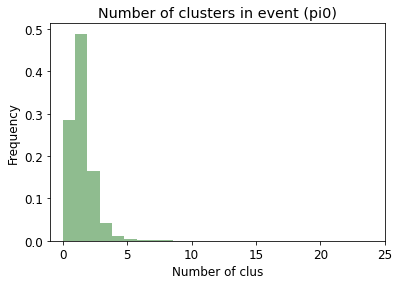

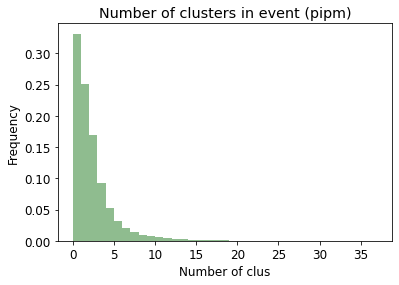

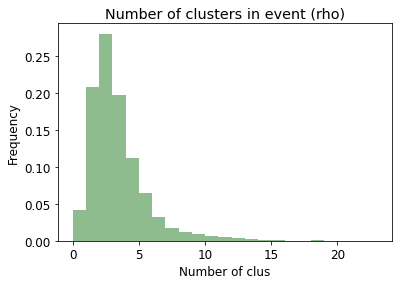

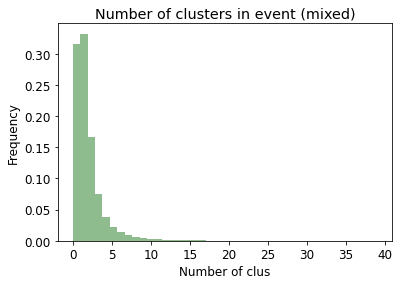

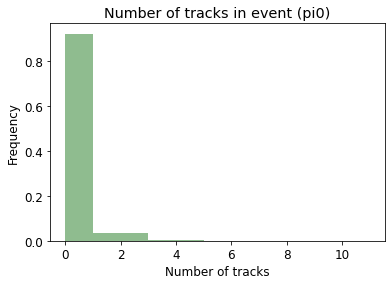

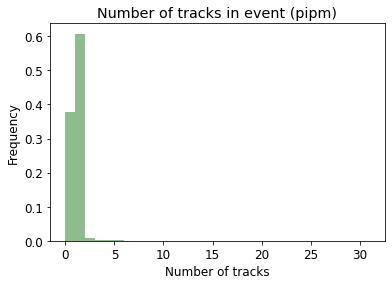

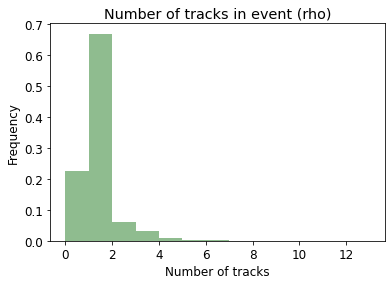

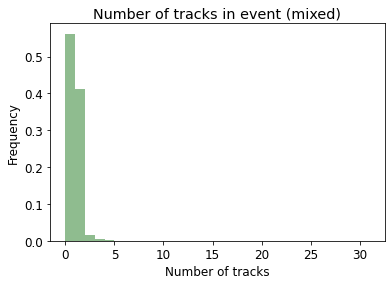

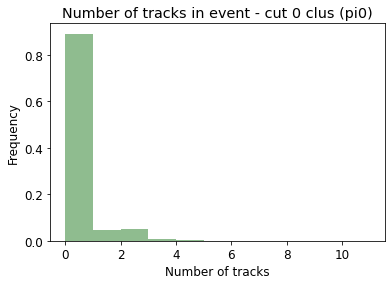

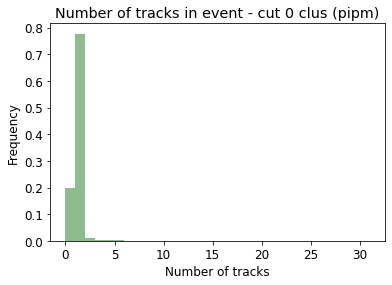

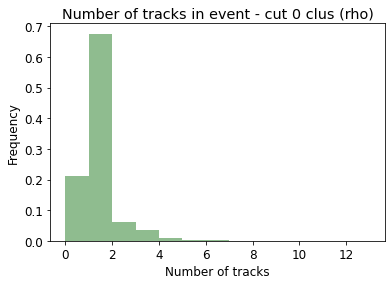

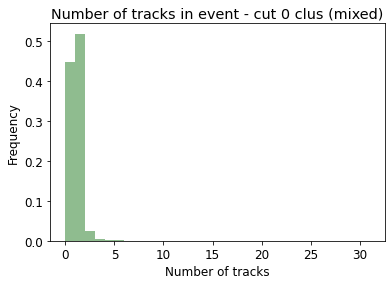

376000
251423


In [1290]:
pi0_nCluster = np.array(pi0_data["nCluster"])
pipm_nCluster = np.array(pipm_data["nCluster"])
pipm2_nCluster = np.array(pipm2_data["nCluster"])
rho_nCluster = np.array(rho_data["nCluster"])
pi0_nTrack = np.array(pi0_data["nTrack"])
pipm_nTrack = np.array(pipm_data["nTrack"])
pipm2_nTrack = np.array(pipm2_data["nTrack"])
rho_nTrack = np.array(rho_data["nTrack"])

pu.plot_hist(pi0_nCluster, 21, "Number of clusters in event (pi0)", "Number of clus", "Frequency", colour="darkseagreen", xlim=(-1,25))
pu.plot_hist(pipm_nCluster, 37, "Number of clusters in event (pipm)", "Number of clus", "Frequency", colour="darkseagreen")
pu.plot_hist(rho_nCluster, 23, "Number of clusters in event (rho)", "Number of clus", "Frequency", colour="darkseagreen")
pu.plot_hist(np.concatenate((pi0_nCluster, pipm_nCluster, pipm2_nCluster)), 41, "Number of clusters in event (mixed)", "Number of clus", "Frequency", colour="darkseagreen")

pu.plot_hist(pi0_nTrack, 11, "Number of tracks in event (pi0)", "Number of tracks", "Frequency", colour="darkseagreen")
pu.plot_hist(pipm_nTrack, 31, "Number of tracks in event (pipm)", "Number of tracks", "Frequency", colour="darkseagreen")
pu.plot_hist(rho_nTrack, 13, "Number of tracks in event (rho)", "Number of tracks", "Frequency", colour="darkseagreen")
pu.plot_hist(np.concatenate((pi0_nTrack, pipm_nTrack, pipm2_nTrack)), 31, "Number of tracks in event (mixed)", "Number of tracks", "Frequency", colour="darkseagreen")

pu.plot_hist(pi0_nTrack[pi0_nCluster != 0], 11, "Number of tracks in event - cut 0 clus (pi0)", "Number of tracks", "Frequency", colour="darkseagreen")
pu.plot_hist(pipm_nTrack[pipm_nCluster != 0], 31, "Number of tracks in event - cut 0 clus (pipm)", "Number of tracks", "Frequency", colour="darkseagreen")
pu.plot_hist(rho_nTrack[rho_nCluster != 0], 13, "Number of tracks in event - cut 0 clus (rho)", "Number of tracks", "Frequency", colour="darkseagreen")
pu.plot_hist(np.concatenate((pi0_nTrack, pipm_nTrack, pipm2_nTrack))[np.concatenate((pi0_nCluster, pipm_nCluster, pipm2_nCluster)) != 0], 31, "Number of tracks in event - cut 0 clus (mixed)", "Number of tracks", "Frequency", colour="darkseagreen")

print(len(pipm_nTrack))
print(len(pipm_nTrack[pipm_nCluster != 0]))


In [210]:
# get track info of processed dataset
pu.plot_hist(processed_event_data['nTrack'], 26, "Number of tracks (mixed dataset)", "Number of tracks", "frequency", colour="darkseagreen")

print("zero tracks:", len(np.array(processed_event_data["nTrack"])[np.array(processed_event_data["nTrack"]) == 0]) / len(processed_event_data["nTrack"]))
print("one track:", len(np.array(processed_event_data["nTrack"])[np.array(processed_event_data["nTrack"]) == 1]) / len(processed_event_data["nTrack"]))
print("2+ tracks:", len(np.array(processed_event_data["nTrack"])[np.array(processed_event_data["nTrack"]) >= 2]) / len(processed_event_data["nTrack"]))

KeyError: 'nTrack'

In [211]:
num_events = len(processed_event_data["nTrack"])

cut_0_tracks = processed_event_data["nTrack"] == 0
cut_1_track = processed_event_data["nTrack"] == 1
cut_multi_tracks = processed_event_data["nTrack"] >= 2
cut_charged_pions = processed_event_data["truth_particle"] == 1

pu.plot_overlay_hist([processed_event_data["nTrack"][cut_charged_pions], processed_event_data["nTrack"][~cut_charged_pions]], 17, "Number of tracks in event (mixed dataset)", "Number of tracks", "Frequency", ["charged", "neutral"], colours=["darkseagreen", "mediumorchid"])
print("0 tracks:", np.count_nonzero(cut_0_tracks)/num_events, "- charged:", np.count_nonzero(cut_0_tracks & cut_charged_pions)/np.count_nonzero(cut_0_tracks))
print("1 track:", np.count_nonzero(cut_1_track)/num_events, "- charged:", np.count_nonzero(cut_1_track & cut_charged_pions)/np.count_nonzero(cut_1_track))
print("2+ tracks:", np.count_nonzero(cut_multi_tracks)/num_events, "- charged:", np.count_nonzero(cut_multi_tracks & cut_charged_pions)/np.count_nonzero(cut_multi_tracks))

KeyError: 'nTrack'

/tmp/ipykernel_59001/3095205173.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cut_data = [flatten_events_to_cells(np.array(processed_event_data[data_key])[cut]) for cut in cuts]


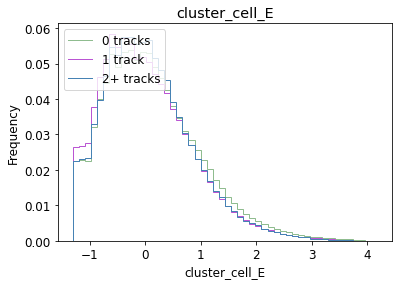

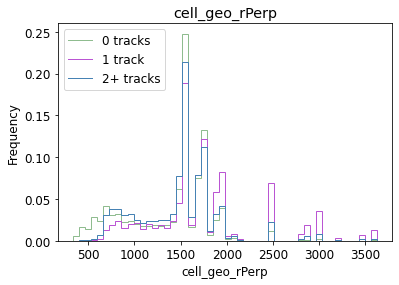

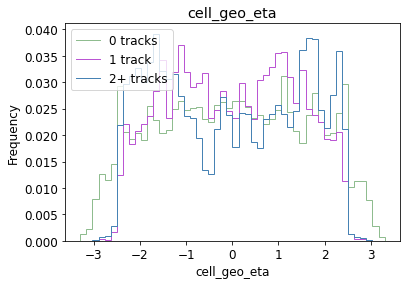

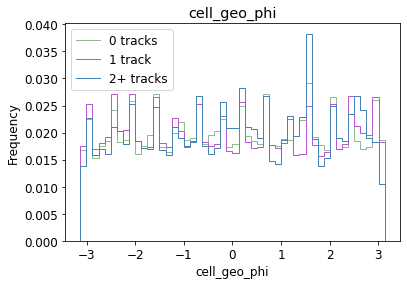

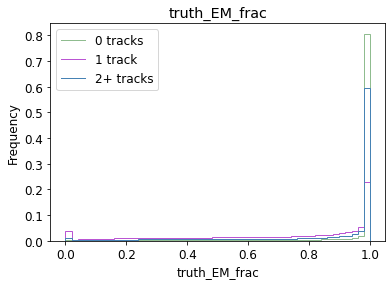

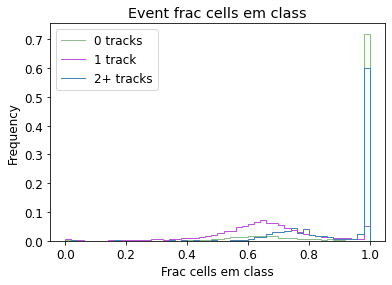

In [191]:
cuts = [cut_0_tracks, cut_1_track, cut_multi_tracks]
cut_labels = ["0 tracks", "1 track", "2+ tracks"]
data_keys = ["cluster_cell_E", "cell_geo_rPerp", "cell_geo_eta", "cell_geo_phi", "truth_EM_frac"]

event_frac_cells_em_class = np.array([np.sum(event_em_frac_class)/len(event_em_frac_class) for event_em_frac_class in flatten_events_and_clus_to_events(processed_event_data["truth_EM_frac"])])

for data_key in data_keys:
    cut_data = [flatten_events_to_cells(np.array(processed_event_data[data_key])[cut]) for cut in cuts]
    pu.plot_overlay_hist(cut_data, 50, data_key, data_key, "Frequency", cut_labels, colours=["darkseagreen", "mediumorchid", "steelblue"], legend_loc="upper left")


pu.plot_overlay_hist([event_frac_cells_em_class[cuts[0]], event_frac_cells_em_class[cuts[1]], event_frac_cells_em_class[cuts[2]]], 50, "Event frac cells em class", "Frac cells em class", "Frequency", cut_labels, colours=["darkseagreen", "mediumorchid", "steelblue"], legend_loc="upper left")


/tmp/ipykernel_59001/4271654011.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  truth_EM_frac_cellwise = flatten_events_to_cells(np.array(processed_event_data[data_key])[cuts[0]])


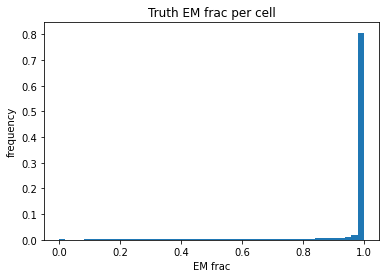

0.999829


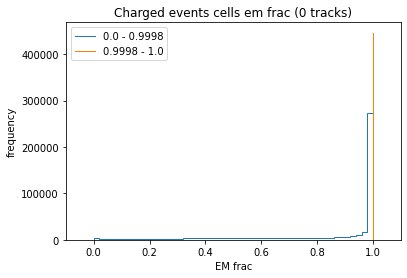

In [66]:
# threshold analysis on separated dataset
title = "Mixed events cells truth em frac (1 track)"
truth_EM_frac_cellwise = flatten_events_to_cells(np.array(processed_event_data[data_key])[cuts[1]])
pu.plot_hist(truth_EM_frac_cellwise, 50, title, "EM frac", "frequency")

# split array into N equal parts
num_class = 2
truth_EM_frac_cellwise_sort = np.sort(truth_EM_frac_cellwise)
truth_EM_frac_cellwise_split = np.array_split(truth_EM_frac_cellwise_sort, num_class)
print(np.max(truth_EM_frac_cellwise_split[0]))

labels = np.arange(num_class)
fig = plt.figure()
fig.patch.set_facecolor('white')
for i, data in enumerate(truth_EM_frac_cellwise_split):
    bins = math.ceil((np.max(data) - np.min(data))*50)
    counts, bins = np.histogram(data, bins, density=False)
    # normalize counts
    plt.stairs(counts, bins, label=str(np.round(np.min(data), 4)) + " - " + str(np.round(np.max(data), 4)))

plt.title(title)
plt.xlabel("EM frac")
plt.ylabel("frequency")
plt.xlim((-0.1,1.1))
plt.legend()
plt.show()


Distances analysis

mean num points in event: 154.21146953405017


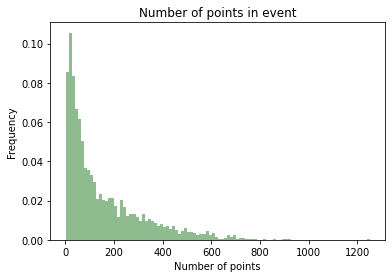

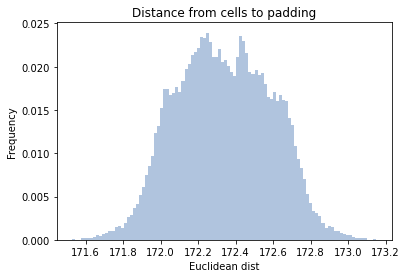

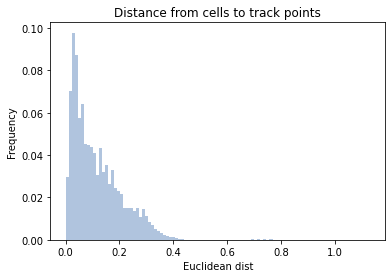

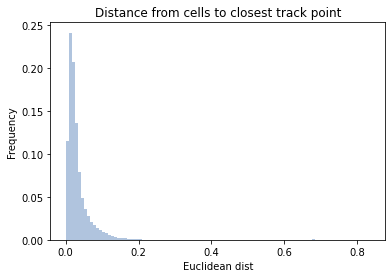

TRACK POINT 0
radius 0.4: 157.06983805668017
radius 0.2: 135.27277327935224
radius 0.1: 116.20900809716599
radius 0.05: 82.2246963562753
radius 0.01: 10.225708502024291


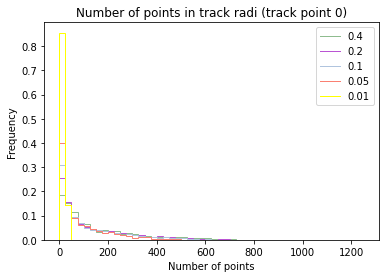

TRACK POINT 1
radius 0.4: 156.96228338430174
radius 0.2: 145.00305810397555
radius 0.1: 119.50611620795107
radius 0.05: 101.46992864424057
radius 0.01: 5.825178389398573


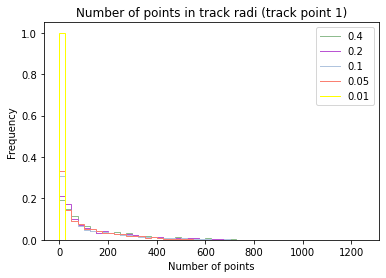

TRACK POINT 2
radius 0.4: 155.9899257688229
radius 0.2: 148.38600212089077
radius 0.1: 126.93372216330859
radius 0.05: 58.04506892895016
radius 0.01: 2.577412513255567


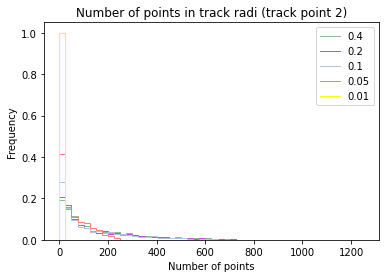

TRACK POINT 3
radius 0.4: 152.1122950819672
radius 0.2: 148.58688524590164
radius 0.1: 125.74590163934427
radius 0.05: 95.74180327868852
radius 0.01: 10.008196721311476


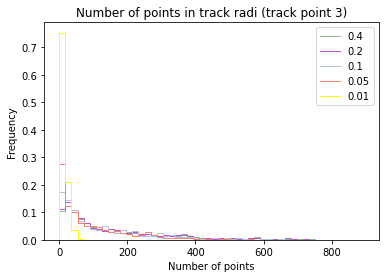

TRACK POINT 4
radius 0.4: 150.7809364548495
radius 0.2: 148.83612040133778
radius 0.1: 128.76755852842808
radius 0.05: 105.43478260869566
radius 0.01: 12.550167224080267


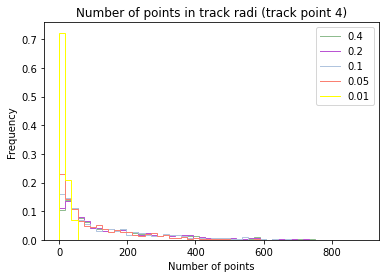

TRACK POINT 5
radius 0.4: 149.0097087378641
radius 0.2: 147.85613415710503
radius 0.1: 131.1685789938217
radius 0.05: 105.58428949691086
radius 0.01: 6.946160635481024


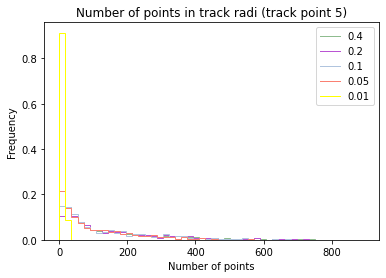

TRACK POINT 6
radius 0.4: 148.44272727272727
radius 0.2: 147.79454545454544
radius 0.1: 136.87272727272727
radius 0.05: 74.73272727272727
radius 0.01: 1.079090909090909


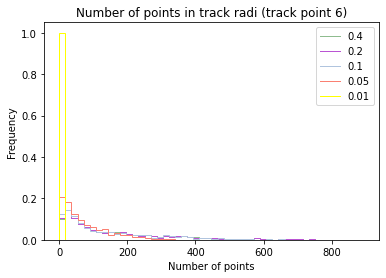

TRACK POINT 7
radius 0.4: 146.14285714285714
radius 0.2: 145.77606177606177
radius 0.1: 116.27123552123552
radius 0.05: 18.44015444015444
radius 0.01: 0.8127413127413128


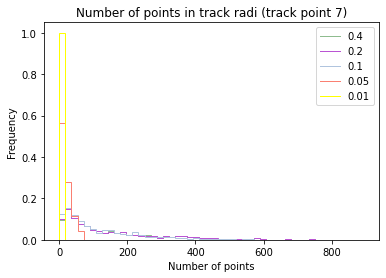

TRACK POINT 8
radius 0.4: 142.02535832414554
radius 0.2: 141.6449834619625
radius 0.1: 34.1135611907387
radius 0.05: 9.845644983461963
radius 0.01: 0.5281146637265711


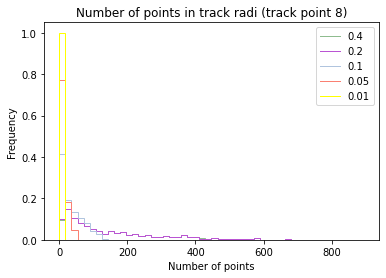

TRACK POINT 9
radius 0.4: 139.65037593984962
radius 0.2: 130.89348370927317
radius 0.1: 20.588972431077693
radius 0.05: 6.507518796992481
radius 0.01: 0.2857142857142857


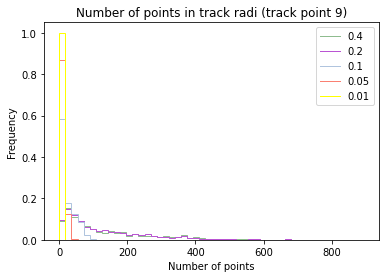

TRACK POINT 10
radius 0.4: 143.84076433121018
radius 0.2: 142.3793347487615
radius 0.1: 54.99504600141543
radius 0.05: 6.282377919320594
radius 0.01: 0.30148619957537154


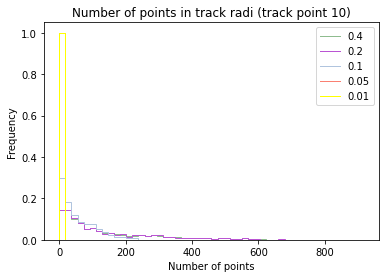

TRACK POINT 11
radius 0.4: 141.85106382978722
radius 0.2: 92.85421591804571
radius 0.1: 20.97478329393223
radius 0.05: 4.288416075650118
radius 0.01: 0.1536643026004728


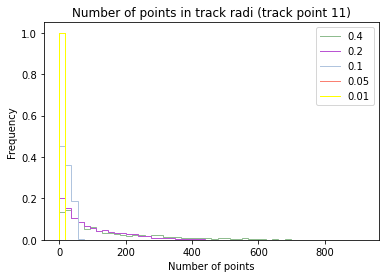

TRACK POINT 12
radius 0.4: 141.01663405088064
radius 0.2: 32.543052837573384
radius 0.1: 7.525440313111546
radius 0.05: 1.0978473581213308
radius 0.01: 0.04403131115459882


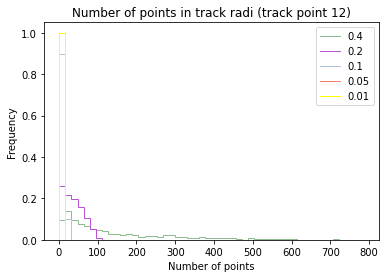

TRACK POINT 13
radius 0.4: 174.7801047120419
radius 0.2: 42.225130890052355
radius 0.1: 11.769633507853403
radius 0.05: 1.2827225130890052
radius 0.01: 0.041884816753926704


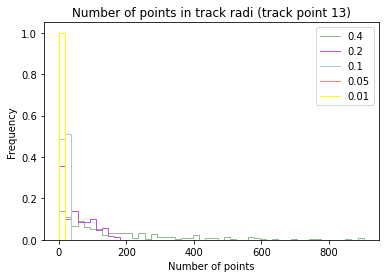

TRACK POINT 14
radius 0.4: 164.87857142857143
radius 0.2: 31.242857142857144
radius 0.1: 4.992857142857143
radius 0.05: 1.0642857142857143
radius 0.01: 0.1


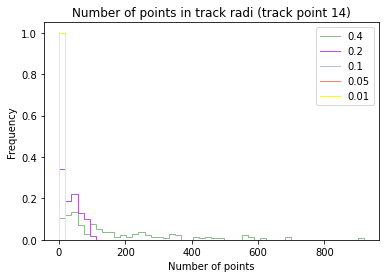

TRACK POINT 15
radius 0.4: 186.1490857946554
radius 0.2: 182.36568213783403
radius 0.1: 65.79606188466948
radius 0.05: 7.208157524613221
radius 0.01: 0.0


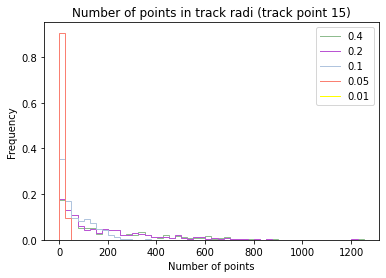

TRACK POINT 16
radius 0.4: 178.87741046831957
radius 0.2: 144.767217630854
radius 0.1: 25.56611570247934
radius 0.05: 3.534435261707989
radius 0.01: 0.19008264462809918


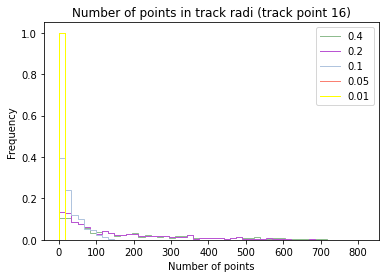

TRACK POINT 17
radius 0.4: 185.20157068062827
radius 0.2: 65.57722513089006
radius 0.1: 14.448952879581151
radius 0.05: 2.4646596858638743
radius 0.01: 0.10471204188481675


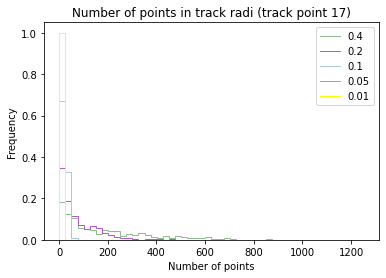

TRACK POINT 18
radius 0.4: 178.23715415019763
radius 0.2: 26.76284584980237
radius 0.1: 4.733860342555995
radius 0.05: 0.9117259552042161
radius 0.01: 0.01844532279314888


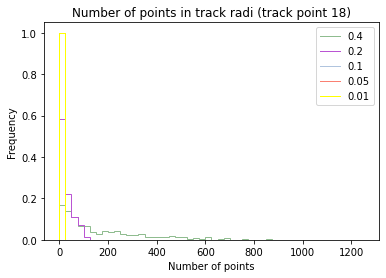

In [79]:
def get_dist(x1, y1, z1, x2, y2, z2):
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2) 

#1 - normalize coords
x = [(np.array(event_x) - (-3626)) / (3626 - (-3626)) for event_x in flatten_events_and_clus_to_events(processed_event_data["x"])]
y = [(np.array(event_y) - (-3626)) / (3626 - (-3626)) for event_y in flatten_events_and_clus_to_events(processed_event_data["y"])]
z = [(np.array(event_z) - (-5906)) / (5906 - (-5906)) for event_z in flatten_events_and_clus_to_events(processed_event_data["z"])]

track_x = np.array([(np.array(event_x) - (-3626)) / (3626 - (-3626)) for event_x in processed_event_track_data["x"]])
track_y = np.array([(np.array(event_y) - (-3626)) / (3626 - (-3626)) for event_y in processed_event_track_data["y"]])
track_z = np.array([(np.array(event_z) - (-5906)) / (5906 - (-5906)) for event_z in processed_event_track_data["z"]])

"""
# plot cells x,y,z distributions
pu.plot_hist(flatten_events_to_clus(x), 100, "Normalized x", "x", "Frequency", colour="mediumorchid")
pu.plot_hist(flatten_events_to_clus(y), 100, "Normalized y", "y", "Frequency", colour="mediumorchid")
pu.plot_hist(flatten_events_to_clus(z), 100, "Normalized z", "z", "Frequency", colour="mediumorchid")

# plot tracks x,y,z distributions
pu.plot_hist(flatten_events_to_clus(track_x)[flatten_events_to_clus(processed_event_track_data["x"]) != 0], 100, "Normalized track x", "Track x", "Frequency", colour="mediumorchid")
pu.plot_hist(flatten_events_to_clus(track_y)[flatten_events_to_clus(processed_event_track_data["y"]) != 0], 100, "Normalized track y", "Track y", "Frequency", colour="mediumorchid")
pu.plot_hist(flatten_events_to_clus(track_z)[flatten_events_to_clus(processed_event_track_data["z"]) != 0], 100, "Normalized track z", "Track z", "Frequency", colour="mediumorchid")
"""
# num points in event
num_points = [len(event_x) for event_x in x]
print("mean num points in event:", np.mean(num_points))
pu.plot_hist(num_points, 100, "Number of points in event", "Number of points", "Frequency", colour="darkseagreen")

# compute distances between cells and padding
dist_from_points_to_padding = get_dist(flatten_events_to_clus(x), flatten_events_to_clus(z), flatten_events_to_clus(x), 100, 100, 100)# padding (0,0,0)
pu.plot_hist(dist_from_points_to_padding, 100, "Distance from cells to padding", "Euclidean dist", "Frequency", colour="lightsteelblue")

# compute distance between cells and all track points
dist_from_cells_to_track = np.full((len(x), 19, 1500), 100.0) # [# events, # tracks = 19, # cells - varries]

for event_idx in range(len(x)):
    for track_idx in range(NUM_TRACK_POINTS):
        if processed_event_track_data["track_bool"][event_idx][track_idx] == 1:
            dist_from_cells_to_track[event_idx, track_idx, :len(x[event_idx])] = get_dist(x[event_idx], y[event_idx], z[event_idx], track_x[event_idx, track_idx], track_y[event_idx, track_idx], track_z[event_idx, track_idx])

pu.plot_hist(flatten_event_to_cells(dist_from_cells_to_track)[flatten_event_to_cells(dist_from_cells_to_track) != 100], 100, "Distance from cells to track points", "Euclidean dist", "Frequency", colour="lightsteelblue")

# compute distance between cells and closest track point
dist_from_cells_to_closest_track = np.min(dist_from_cells_to_track, 1)
pu.plot_hist(flatten_one_layer(dist_from_cells_to_closest_track)[flatten_one_layer(dist_from_cells_to_closest_track) != 100], 100, "Distance from cells to closest track point", "Euclidean dist", "Frequency", colour="lightsteelblue")


# compute num points in certain radii
radii = [0.4, 0.2, 0.1, 0.05, 0.01]
track_bools = np.transpose(np.array(processed_event_track_data["track_bool"]), (1, 0))

for track_idx in range(NUM_TRACK_POINTS):
    print("TRACK POINT", track_idx)
    num_points_in_radii = [np.array([np.count_nonzero(event_dists[track_idx, :] <= radi) for event_dists in dist_from_cells_to_track])[track_bools[track_idx] == 1] for radi in radii]
    for i, radius in enumerate(radii):
        print("radius " + str(radius) + ":", np.mean(num_points_in_radii[i]))

    pu.plot_overlay_hist(num_points_in_radii, 50, "Number of points in track radi (track point " + str(track_idx) + ")", "Number of points", "Frequency", radii, colours=["darkseagreen", "mediumorchid", "lightsteelblue", "salmon", "yellow"])

In [132]:
import torch

In [144]:
arr = torch.tensor([[[1,1,4,5,5],[0,2,3,3,3],[9,0,1,2,1]]], dtype=torch.long)
unique_arr = torch.argmin(arr, dim=-1)#, dim=1, return_inverse=True)

print("argmin", unique_arr,'\n')
#print("inverse_idx", inverse_idx)

arr tensor([[[1, 1, 4, 5, 5],
         [0, 2, 3, 3, 3],
         [9, 0, 1, 2, 1]]]) 

unique tensor([[0, 0, 1]]) 



In [143]:
output = torch.unique(torch.tensor([1, 3, 2, 3], dtype=torch.long))
output, inverse_indices = torch.unique(torch.tensor([1, 3, 2, 3], dtype=torch.long), sorted=True, return_inverse=True)
print(output)
print(inverse_indices)

output, inverse_indices = torch.unique(torch.tensor([[1, 3], [2, 3]], dtype=torch.long), dim=0, sorted=True, return_inverse=True)
print(output)
print(inverse_indices)

tensor([1, 2, 3])
tensor([0, 2, 1, 2])
tensor([[1, 3],
        [2, 3]])
tensor([0, 1])


In [155]:
arr = torch.tensor([[0,0,1],[2,2,2,],[4,3,2]])

output, idx = torch.sort(arr, dim=-1)

print("arr:", arr)
print("outut:", output)
print("idx:", idx)

print(torch.bincount(output[0]))
print(torch.bincount(output[1]))
print(torch.bincount(output[2]))

arr: tensor([[0, 0, 1],
        [2, 2, 2],
        [4, 3, 2]])
outut: tensor([[0, 0, 1],
        [2, 2, 2],
        [2, 3, 4]])
idx: tensor([[0, 1, 2],
        [0, 1, 2],
        [2, 1, 0]])
tensor([2, 1])
tensor([0, 0, 3])
tensor([0, 0, 1, 1, 1])
